# A genetic algorithm to select peptide sequences


In [ ]:
!pip install matplotlib numpy tqdm seaborn "seqme[aa_descriptors, hyformer]==0.3.4" "hyformer @ git+https://github.com/szczurek-lab/hyformer.git@v2.0"

In [2]:
%load_ext autoreload
%autoreload 2

from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns

import seqme as sm

/Users/rasmus.larsen/work/hackathon-2025/seqme-reproducibility/.conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Setup


In [3]:
# WORKDIR_PATH = Path("./docs/tutorials")
WORKDIR_PATH = Path("./..")

In [4]:
# POOL_PATH = WORKDIR_PATH / "data" / "gpt2" / "ampsphere_10_50_836941.fasta"
POOL_PATH = WORKDIR_PATH / "data" / "dbs" / "uniprot" / "uniprot_8_50_100.fasta"

CACHE_PATH = WORKDIR_PATH / "cache" / "pool.pkl"

PRECOMPUTE_CACHE = False

In [5]:
POOL_SIZE = 10_000
BAG_SIZE = 500

N_ITERATIONS = 3200
GENERATION_SIZE = 24

Let's load the pool into memory.

In [6]:
pool = sm.read_fasta(POOL_PATH)
pool = sm.utils.subsample(pool, POOL_SIZE)

## Cache precomputing


Let's precompute the sequences in the cache immediately.


In [7]:
if PRECOMPUTE_CACHE:
    hyformer = sm.models.Hyformer(sm.models.HyformerCheckpoint.peptides_34M)
    hyformer_mic = sm.models.Hyformer(sm.models.HyformerCheckpoint.peptides_34M_mic)

    models = {
        "hyformer": hyformer.embed,
        "hyformer-perplexity": hyformer.compute_perplexity,
        "hyformer-mic": hyformer_mic.predict,
        "charge": sm.models.Charge(),
    }
    cache = sm.Cache(models=models)

    for bag_name in tqdm(models.keys()):
        model = cache.model(bag_name)
        model(pool)

    sm.to_pickle(cache.get(), CACHE_PATH)

## Run


Let's load the cache.


In [8]:
precomputed = sm.read_pickle(CACHE_PATH)
cache = sm.Cache(init_cache=precomputed)

Let's define the metrics.


In [9]:
metrics = [
    # sm.metrics.Count(),
    # sm.metrics.Length(),
    sm.metrics.Uniqueness(),
    sm.metrics.Diversity(k=30),
    # sm.metrics.ID(sm.models.Charge(), "Charge", "minimize"),
    # sm.metrics.FKEA(cache.model("hyformer"), bandwidth=5.0, n_random_fourier_features=128),
    # sm.metrics.ID(cache.model("hyformer-perplexity"), "Perplexity (Hyformer)", "minimize"),
    sm.metrics.ID(cache.model("hyformer-mic"), "log MIC", "minimize"),
    # sm.metrics.Recall(n_neighbors=5, reference=pool, embedder=cache.model("hyformer"), strict=False),
]

rank_by = ["FKEA", "log MIC"]
rank_by = ["Diversity", "log MIC"]
# rank_by = ["log MIC"]

Let's run the algorithm to select the bags of sequences.


In [10]:
import math


def pile_sample(
    generation_size: int,
    bag_size: int,
    df_gen: pd.DataFrame,
    indices_per_bag: np.ndarray,
    extra_indices: np.ndarray,
    *,
    extra_indices_frac: float = 0.0,
    **kwargs,
) -> np.ndarray:
    df_best = sm.top_k(df_gen, "Rank (generation)", k=1, keep="all")
    best_pool = {int(idx) for bag in df_best.index for idx in indices_per_bag[bag]}
    extra_pool = set(extra_indices) - best_pool

    best_pool = list(best_pool)
    extra_pool = list(extra_pool)

    def sample_bag():
        extra_size = math.floor(extra_indices_frac * bag_size)
        if extra_size > 0:
            extra_selected_indices = np.random.choice(extra_pool, size=extra_size, replace=False)
        best_indices = np.random.choice(best_pool, size=bag_size - extra_size, replace=False)
        return np.concat([best_indices, extra_selected_indices]) if extra_size > 0 else best_indices

    return [sample_bag() for _ in range(generation_size)]


def crossover_sample(
    generation_size: int,
    bag_size: int,
    df_gen: pd.DataFrame,
    indices_per_bag: np.ndarray,
    extra_indices: np.ndarray,
    *,
    extra_indices_frac: float = 0.0,
    min_best: int | None = None,
    **kwargs,
) -> np.ndarray:
    df_best = sm.top_k(df_gen, "Rank (generation)", k=1, keep="all")

    if min_best and len(df_best) < min_best:
        df_best = sm.sort(df_gen, "Rank (generation)")
        df_best = df_best.iloc[:min_best]

    best_pool = {int(idx) for bag in df_best.index for idx in indices_per_bag[bag]}
    extra_pool = set(extra_indices.tolist()) - best_pool

    best_pool = list(best_pool)
    extra_pool = list(extra_pool)

    def sample_bag():
        parent_ilocs = np.random.choice(np.arange(len(df_best)), size=2)
        parent_bags = df_best.index[parent_ilocs]
        parents_pool = {int(idx) for bag in parent_bags for idx in indices_per_bag[bag]}

        extra_size = math.floor(extra_indices_frac * bag_size)
        if extra_size > 0:
            extra_selected_indices = np.random.choice(extra_pool, size=extra_size, replace=False)
        parent_indices = np.random.choice(list(parents_pool), size=bag_size - extra_size, replace=False)
        return np.concat([parent_indices, extra_selected_indices]) if extra_size > 0 else parent_indices

    return [sample_bag() for _ in range(generation_size)]


def pool_sample(
    generation_size: int,
    bag_size: int,
    df_gen: pd.DataFrame,
    indices_per_bag: np.ndarray,
    extra_indices: np.ndarray,
    **kwargs,
) -> np.ndarray:
    return [np.random.choice(extra_indices, size=bag_size) for _ in range(generation_size)]

In [11]:
df_all = []
indices_per_bag = {}

extra_indices = np.arange(len(pool))

# First generation of bags
gen_bag_indices = [np.random.choice(extra_indices, size=BAG_SIZE, replace=False) for _ in range(GENERATION_SIZE)]

for idx_iter in tqdm(range(N_ITERATIONS)):
    # Evaluate generation
    dfs_gen = []
    for idx_gen in range(GENERATION_SIZE):
        bag_indices = gen_bag_indices[idx_gen]
        bag_sequences = [pool[i] for i in bag_indices]

        bag_name = (idx_iter, idx_gen)
        indices_per_bag[bag_name] = bag_indices
        df_bag = sm.evaluate(sequences={bag_name: bag_sequences}, metrics=metrics, verbose=False)
        dfs_gen += [df_bag]

    # Combine and rank generation
    df_gen = sm.combine(dfs_gen)
    df_gen = sm.rank(df_gen, metrics=rank_by, name="Rank (generation)")
    df_all += [df_gen]

    # frac = np.interp(idx_iter / N_ITERATIONS, [0, 0.1, 1.0], [0.1, 0.025, 0.0])
    frac = np.interp(idx_iter, [0, 300, N_ITERATIONS], [0.05, 0.02, 0.0])
    # frac = 0.05
    gen_bag_indices = crossover_sample(
        GENERATION_SIZE,
        BAG_SIZE,
        df_gen,
        indices_per_bag,
        extra_indices,
        extra_indices_frac=frac,
        min_best=None,
    )

df = sm.combine(df_all)

100%|██████████| 3200/3200 [20:20<00:00,  2.62it/s]


Let's compute the global rank.

In [12]:
df = sm.rank(df, metrics=rank_by)

In [13]:
len(df)

76800

Let's display a subset of the bags.

In [14]:
# sm.show(df, color="#fd82ff", level=1, color_style="bar", n_decimals=[0, 2, 2, 3, 2, 2, 2, 2, 0, 0])
# sm.show(df[["log MIC"]], color="#fd82ff", level=1, color_style="bar")

In [15]:
rank_col = ("Rank (generation)", "value")
idx = df[rank_col].groupby(level=0).idxmin().tolist()
df_gen_best = df.loc[idx]
df_gen_best.index = pd.MultiIndex.from_tuples([("Bag", i) for i in range(len(df_gen_best))], names=[None, None])

In [16]:
cmap = plt.get_cmap("viridis")
K = len(df_gen_best)
colors = [cmap(i / (K - 1)) for i in range(K)]

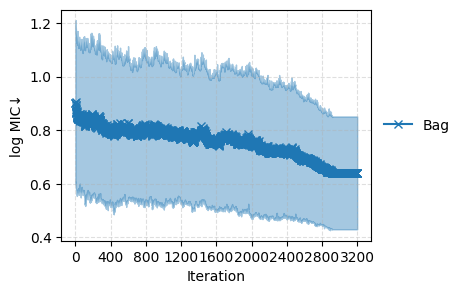

In [17]:
sm.plot_line(df_gen_best, "log MIC")

In [18]:
df2 = df_gen_best.xs("Bag", level=0)

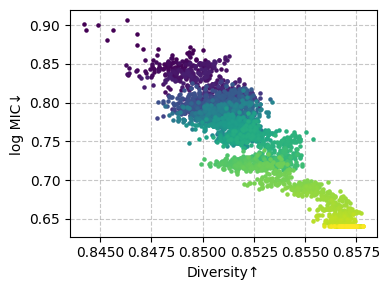

In [19]:
fig, ax = plt.subplots(figsize=(4, 3))
sm.plot_scatter(
    df2,
    metrics=rank_by,
    marker=None,
    linestyle=None,
    show_deviation=False,
    marker_size=5,
    color=colors,
    ax=ax,
)
ax.legend().set_visible(False)
fig.tight_layout()
#ax.colorbar()
fig.savefig("../figs/case1/pareto_front.png")


In [20]:
sm.top_k(df, metric="Rank", k=1, keep="all")

Uniqueness           Diversity             log MIC            \
             value deviation     value deviation     value deviation   
2807 21        1.0       NaN  0.857938       NaN  0.659840  0.209851   
2878 14        1.0       NaN  0.857883       NaN  0.656242  0.225817   
2899 2         1.0       NaN  0.857862       NaN  0.648674  0.213083   
2914 6         1.0       NaN  0.857110       NaN  0.640153  0.209665   
3148 4         1.0       NaN  0.857822       NaN  0.640799  0.210648   
3183 1         1.0       NaN  0.857836       NaN  0.640799  0.210648   

        Rank (generation)            Rank            
                    value deviation value deviation  
2807 21               1.0       NaN     1       NaN  
2878 14               1.0       NaN     1       NaN  
2899 2                1.0       NaN     1       NaN  
2914 6                1.0       NaN     1       NaN  
3148 4                1.0       NaN     1       NaN  
3183 1                1.0       NaN     1       NaN

In [21]:
bag_name = (3151, 11)

bag_indices = indices_per_bag[bag_name]
bag_sequences = [pool[i] for i in bag_indices]

In [22]:
log_mic_fn = cache.model("hyformer-mic")

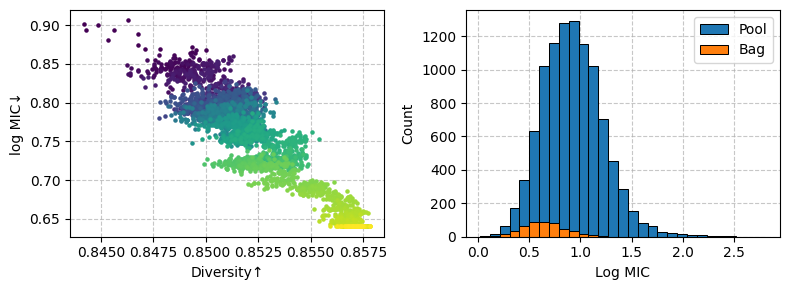

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(8, 3))

ax = axes[0]
sm.plot_scatter(
    df2,
    metrics=rank_by,
    marker=None,
    linestyle=None,
    show_deviation=False,
    marker_size=5,
    color=colors,
    ax=ax,
)
ax.legend().set_visible(False)
fig.tight_layout()
#ax.colorbar()

ax = axes[1]

vs1 = log_mic_fn(pool)[:, 0]
vs2 = log_mic_fn(bag_sequences)[:, 0]

all_data = np.concatenate([vs1, vs2])
bins = np.linspace(all_data.min(), all_data.max(), 30)

sns.histplot(vs1, ax=ax, alpha=1, label="Pool", bins=bins)
sns.histplot(vs2, ax=ax, alpha=1, label="Bag", bins=bins)

ax.set_xlabel("Log MIC")
ax.grid(axis="both", linestyle="--", alpha=0.7)
ax.set_axisbelow(True)

ax.legend()

fig.tight_layout()
fig.savefig("../figs/case3/both.png", bbox_inches='tight', dpi=300)
